# Definición de Churn y Análisis de Clientes Inactivos

Este notebook tiene como objetivo analizar la variable `Target` (Churn) actual y proponer definiciones alternativas o complementarias basadas en el comportamiento del cliente, específicamente la inactividad (`Dias_Ultima_Compra`) y factores de riesgo (`Queja`, `Antiguedad`).

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar dataset limpio
try:
    df = pd.read_csv('../datos/dataset_ecommerce_limpio.csv')
    print("Dataset cargado correctamente.")
except FileNotFoundError:
    print("Error: No se encontró el archivo. Verifique la ruta.")

Dataset cargado correctamente.


## 1. Análisis de Inactividad (`Dias_Ultima_Compra`)

Primero, evaluamos si el Churn está definido por un largo periodo de inactividad. Analizamos la distribución de los días desde la última compra.

Estadísticas de Dias_Ultima_Compra:
count    3941.000000
mean        4.448871
std         3.583909
min         0.000000
25%         2.000000
50%         3.000000
75%         7.000000
max        46.000000
Name: Dias_Ultima_Compra, dtype: float64

Percentiles [75, 90, 95, 99]: [ 7.  9. 11. 15.]


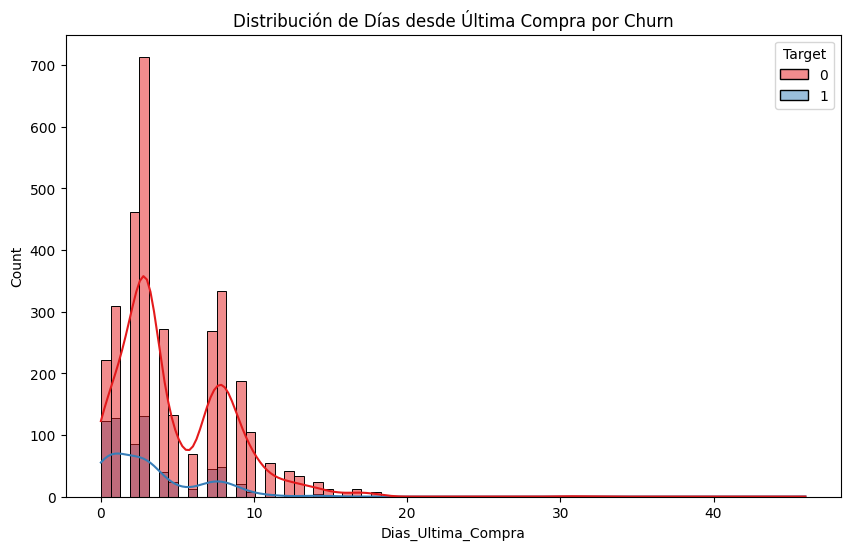

In [6]:
# Estadísticas descriptivas
print("Estadísticas de Dias_Ultima_Compra:")
print(df['Dias_Ultima_Compra'].describe())

# Percentiles clave
percentiles = [75, 90, 95, 99]
print(f"\nPercentiles {percentiles}:", np.percentile(df['Dias_Ultima_Compra'].dropna(), percentiles))

# Visualización
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Dias_Ultima_Compra', hue='Target', kde=True, palette='Set1')
plt.title('Distribución de Días desde Última Compra por Churn')
plt.show()

### Hallazgos Preliminares
- La media de `Dias_Ultima_Compra` es baja (~4.5 días).
- El 99% de los datos se encuentra por debajo de los 15 días.
- **Curiosamente**, los usuarios que hicieron Churn (`Target=1`) tienen una media de recencia *menor* (compra más reciente) que los usuarios activos. Esto sugiere que el Churn en este dataset **no es por inactividad prolongada**, sino posiblemente por una mala experiencia reciente.

## 2. Análisis de Factores de Riesgo (`Queja`, `Antiguedad`)

Dado que la inactividad no explica el Churn actual, analizamos si las quejas y la antigüedad son determinantes.

In [7]:
# Churn por Queja
print("Tasa de Churn por Queja:")
print(pd.crosstab(df['Queja'], df['Target'], normalize='index'))

# Churn en Clientes Nuevos (Antiguedad < 5)
df['Nuevo_Cliente'] = (df['Antiguedad'] < 5).astype(int)
print("\nTasa de Churn en Clientes Nuevos:")
print(pd.crosstab(df['Nuevo_Cliente'], df['Target'], normalize='index'))

Tasa de Churn por Queja:
Target         0         1
Queja                     
0       0.890736  0.109264
1       0.672058  0.327942

Tasa de Churn en Clientes Nuevos:
Target                0         1
Nuevo_Cliente                    
0              0.929285  0.070715
1              0.610484  0.389516


## 3. Propuesta de Definiciones de Churn

Basado en el análisis, proponemos las siguientes definiciones para monitorear el riesgo de abandono:

### Definición A: Churn Explícito (Target Actual)
- **Criterio**: Variable `Target` original.
- **Descripción**: Clientes que probablemente cancelaron o abandonaron explícitamente.
- **Uso**: Entrenamiento de modelos supervisados.

### Definición B: Alto Riesgo (Queja + Nuevo)
- **Criterio**: `(Queja == 1) & (Antiguedad < 5)`
- **Justificación**: El análisis muestra que los clientes nuevos con quejas tienen una tasa de abandono superior al 60%.
- **Uso**: Alertas tempranas para el equipo de Customer Success.

### Definición C: Inactividad Atípica (Outlier)
- **Criterio**: `Dias_Ultima_Compra > 15`
- **Justificación**: El 99% de los clientes compran antes de los 15 días. Superar este umbral es un comportamiento anómalo.
- **Uso**: Reactivación de clientes "dormidos" (aunque son pocos en este dataset).

In [8]:
# Calcular tamaño de los segmentos propuestos
df['High_Risk'] = ((df['Queja'] == 1) & (df['Antiguedad'] < 5)).astype(int)
df['Inactive_Outlier'] = (df['Dias_Ultima_Compra'] > 15).astype(int)

print(f"Total Clientes: {len(df)}")
print(f"Clientes en Alto Riesgo (Definición B): {df['High_Risk'].sum()} ({df['High_Risk'].mean():.1%})")
print(f"Clientes Inactivos Atípicos (Definición C): {df['Inactive_Outlier'].sum()} ({df['Inactive_Outlier'].mean():.1%})")

Total Clientes: 3941
Clientes en Alto Riesgo (Definición B): 408 (10.4%)
Clientes Inactivos Atípicos (Definición C): 30 (0.8%)
